In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporitng int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
                    
        def _backward():
            self.grad += out.grad * other * self.data ** (other-1)
    
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += out.grad * (1-t**2)
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.grad * out.data
        
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [36]:
a = Value(2.0)
a+1, a*2, 2*a, a.exp(), a / 3, a - 3

(Value(data=3.0),
 Value(data=4.0),
 Value(data=4.0),
 Value(data=7.38905609893065),
 Value(data=0.6666666666666666),
 Value(data=-1.0))

In [37]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record) node for it')
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            # and connect this node to it
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        

In [38]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'

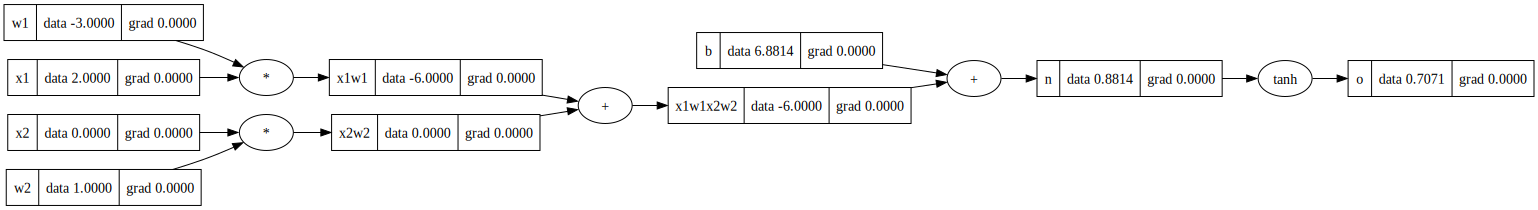

In [39]:
draw_dot(o)

In [40]:
o.backward()

In [41]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# ------
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1)
# ------

o.label = 'o'
o.backward()

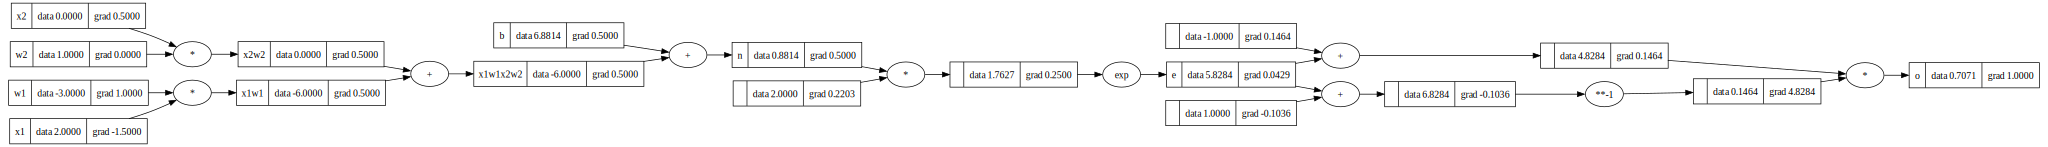

In [42]:
draw_dot(o)

In [43]:
import random
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [44]:
x = [2.0, 3.0, -1.0]
n = Neuron(3)
l = Layer(3, 4)
mlp = MLP(3, [4, 4, 1])
n(x), l(x), mlp(x)

(Value(data=-0.7003016725716531),
 [Value(data=-0.6748996090311199),
  Value(data=-0.9683928679840174),
  Value(data=-0.4648898405965861),
  Value(data=0.6640584034087)],
 Value(data=0.5790056051330299))

In [45]:
n.w

[Value(data=-0.9137088787032319),
 Value(data=0.3160109593324254),
 Value(data=0.42875515130387565)]

In [46]:
[n.w for n in l.neurons]

[[Value(data=0.23363897073887085),
  Value(data=-0.52534006730357),
  Value(data=-0.6861493231743043)],
 [Value(data=-0.5359818236786931),
  Value(data=-0.46399862465741926),
  Value(data=-0.05260395874216783)],
 [Value(data=-0.8850406971110101),
  Value(data=0.38682720113590463),
  Value(data=-0.11593438995369909)],
 [Value(data=-0.784080259005393),
  Value(data=0.8811981344235862),
  Value(data=0.762392909053063)]]

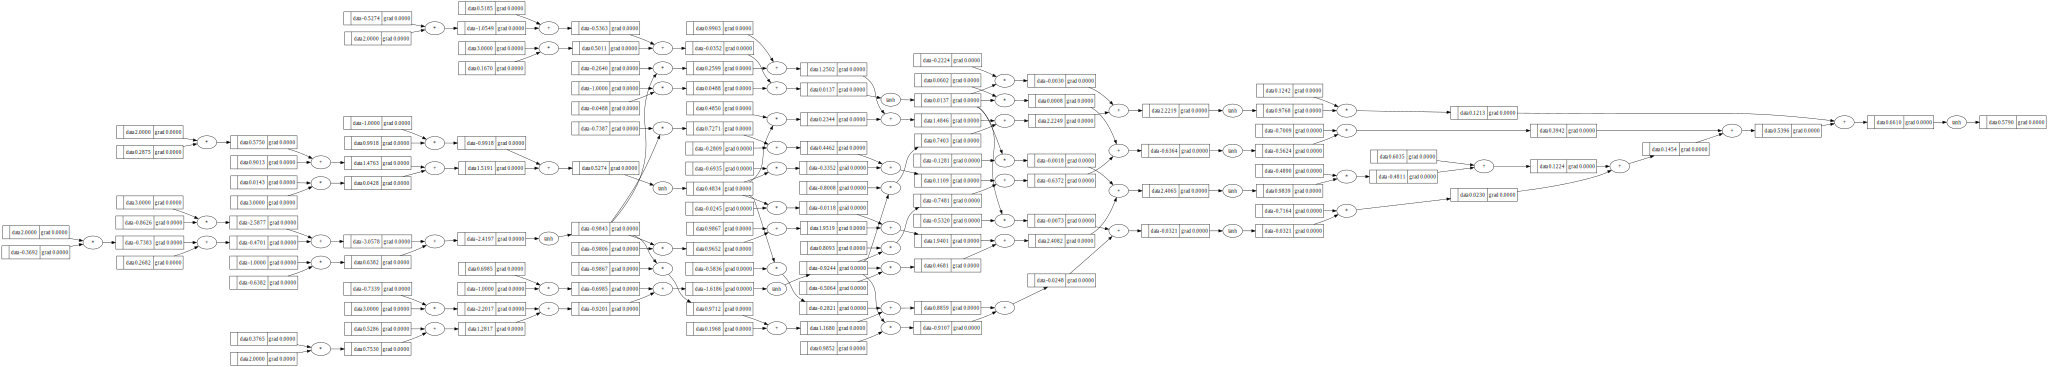

In [47]:
draw_dot(mlp(x))

In [48]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [49]:
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.5790056051330299),
 Value(data=-0.26481945022424447),
 Value(data=-0.37433700818170595),
 Value(data=0.6504670628340665)]

In [50]:
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.2313541747728516)

In [51]:
list(ypred[0]._prev)[0]._prev

{Value(data=0.12134583439413171), Value(data=0.5396196877608818)}

In [52]:
loss.backward()

In [53]:
mlp.layers[0].neurons[0].w[0].grad

3.124233461746945

In [55]:
mlp.parameters()

[Value(data=-0.369167959663548),
 Value(data=-0.8625703154832656),
 Value(data=-0.6381571182574237),
 Value(data=0.268203336977179),
 Value(data=0.2875092647214639),
 Value(data=0.014276398556768655),
 Value(data=0.9917513742774708),
 Value(data=0.9012698345525567),
 Value(data=0.37652270715753966),
 Value(data=-0.7339088062525108),
 Value(data=0.698518333577522),
 Value(data=0.5286180371698193),
 Value(data=-0.5274275662711516),
 Value(data=0.16704764294835606),
 Value(data=-0.04884541814511567),
 Value(data=0.518547944130435),
 Value(data=-0.9805966467177318),
 Value(data=-0.02447092563290032),
 Value(data=-0.5064230809441905),
 Value(data=-0.12809485559416345),
 Value(data=0.9867289423249586),
 Value(data=-0.9867064373746262),
 Value(data=-0.5836456159652008),
 Value(data=0.9851786593893475),
 Value(data=-0.5320007282750219),
 Value(data=0.1967863927883804),
 Value(data=-0.7386689390358685),
 Value(data=-0.6935271151935256),
 Value(data=0.8093048573699946),
 Value(data=0.06019063814